# Question 2

The following data warehouse stores information on patient accesses (characterized by age range
and gender) to the emergency room of hospitals located in Italy. Each hospital belongs to a single
type (public or private) and there may be one or more departments among pediatrics, geriatrics,
orthopedics, and cardiology (these attributes are Boolean and represent a configuration). In the
Triage a color code (among white, green, blue, yellow, and red) is assigned and the mode of
access to the emergency room (by ambulance or independently) is tracked. When someone
accesses the emergency room, a diagnosis characterized by one or more specialistic
examinations is assigned.

The data warehouse is characterized by the following conceptual schema and corresponding
logical schema. Each event is characterized by four measures: number of patients, number of
visits, number of physicians who made the visits and hours spent in the emergency room
(TotalHours).

![Screenshot 2024-02-19 150834.png](<attachment:Screenshot 2024-02-19 150834.png>)

Given the following logical schema, write in the box below the following extended SQL queries,
separated by a space.

```SQL
CREATE TABLE
    PATIENT_CHARACTERISTICS (
        CodCP INT PRIMARY KEY,
        AgeRange VARCHAR(50),
        Gender CHAR(1)
    );

CREATE TABLE
    TRIAGE (
        CodTriage INT PRIMARY KEY,
        AccessMode VARCHAR(50),
        ColorCode VARCHAR(50)
    );

CREATE TABLE
    HOSPITAL (
        CodO INT PRIMARY KEY,
        Hospital VARCHAR(100),
        Typology VARCHAR(50),
        City VARCHAR(50),
        Province VARCHAR(50),
        Region VARCHAR(50),
        Pediatrics BOOLEAN,
        Geriatrics BOOLEAN,
        Orthopedics BOOLEAN,
        Cardiology BOOLEAN
    );

CREATE TABLE
    DIAGNOSIS (
        CodD INT PRIMARY KEY,
        Diagnosis VARCHAR(100),
        Illness VARCHAR(100)
    );

CREATE TABLE
    EXAM_DIAGNOSIS (
        CodD INT PRIMARY KEY,
        SpecialisticExamination VARCHAR(100),
        FOREIGN KEY (CodD) REFERENCES DIAGNOSIS (CodD)
    );

CREATE TABLE
    TIME(
        CodT INT PRIMARY KEY,
        Date DATE,
        DayOfWeek INT,
        Week INT,
        DayOfMonth INT,
        Holiday BOOLEAN,
        Month INT,
        MonthOfYear INT,
        FourMonths INT,
        SixMonths INT,
        Year INT
    );

CREATE TABLE
    EMERGENCY_ROOM_ACCESS (
        CodCP INT,
        CodTriage INT,
        CodO INT,
        CodD INT,
        CodT INT,
        Patients INT,
        Visits INT,
        Physicians INT,
        TotalHours INT,
        PRIMARY KEY (CodCP, CodTriage, CodO, CodD, CodT),
        FOREIGN KEY (CodCP) REFERENCES PATIENT_CHARACTERISTICS (CodCP),
        FOREIGN KEY (CodTriage) REFERENCES TRIAGE (CodTriage),
        FOREIGN KEY (CodO) REFERENCES HOSPITAL (CodO),
        FOREIGN KEY (CodD) REFERENCES DIAGNOSIS (CodD),
        FOREIGN KEY (CodT) REFERENCES TIME(CodT)
    );
```
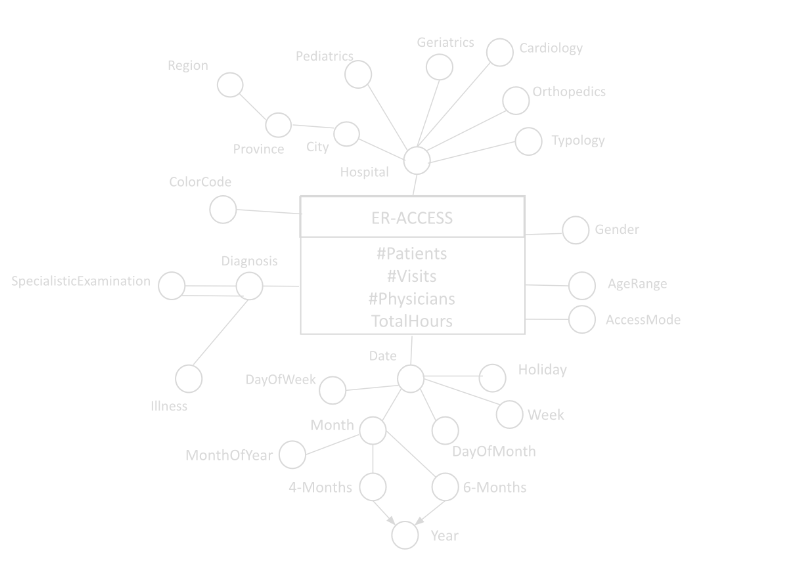

## Query 1 (3 points)

Considering female patients in the 24-34 age range, separately by four-month period (4-Months)
and province, show:

- the average number of visits per physician, the average number of hours spent in the
  emergency room per patient
- the percentage of the number of hours spent in the emergency room compared to the total
  number of hours spent in the emergency room by region
- the cumulative number of visits for increasing four-month period (4-Months), separately by
  year.

Perform the analysis separately by mode of access (AccessMode) to the emergency room.


In [ ]:
SELECT
    FourMonths,
    Province,
    AccessMode,
    SUM(er.Visits) / SUM(Physicians),
    SUM(TotalHours) / SUM(Patients),
    100 * SUM(TotalHours) / SUM(
        SUM(TotalHours) OVER
        PARTITION BY
            FourMonths,
            AccessMode,
            Region
    ),
    SUM(
        SUM(Visits) OVER
        PARTITION BY
            Province,
            AccessMode,
            Year
        ORDER BY
            FourMonths ROWS UNBOUNDED PRECEDING
    )
FROM
    TIME t,
    HOSPITAL h,
    EMERGENCY_ROOM_ACCESS er,
    PATIENT_CHARACTERISTICS pc
WHERE
    t.CodT = = er.CodT
    AND h.CodO = = er.CodO
    AND pc.CodCP = = er.CodCP
    AND pc.Gender = = 'F'
    AND pc.AgeRange = = "24-34"
GROUP BY
    FourMonths,
    AccessMode,
    Year,
    Region,
    Province

## Query 2 (4 points)

Considering the accesses to the emergency room with red code (ColorCode) made by female
patients, separately by diagnosis, province and four-month period (4-Months), show:

- the average monthly number of visits
- the average number of patients per physician
- the total number of patients regardless of diagnosis and region
- the total number of hours spent in the emergency room regardless of the four-month period (4-
  Months).

Perform the analysis separately for public and private hospitals.


In [ ]:
SELECT
    Diagnosis,
    Province,
    FourMonths,
    SUM(Visits) / COUNT(DISTINCT Month),
    SUM(Patients) / SUM(Physicians),
    SUM(
        SUM(Patients) OVER
        PARTITION BY
            Typology,
            FourMonths
    ),
    SUM(
        SUM(TotalHours) OVER
        PARTITION BY
            Typology,
            Diagnosis,
            Province
    )
FROM
    PATIENT_CHARACTERISTICS pc,
    TRIAGE tr,
    EMERGENCY_ROOM_ACCESS er,
    TIME t
WHERE
    er.CodCP = pc.CodCP
    AND tr.CodTriage = = er.CodTriage
    AND er.CodT = = t.CodT
    AND pc.Gender = = 'F'
    AND tr.ColorCode = = 'red'
GROUP BY
    Diagnosis,
    Province,
    FourMonths,
    Typology

## Query 3 (4 points)

Separately by month and city where a hospital is located, show:

- the average daily number of hours spent in the emergency room
- the percentage of patients compared to the total of the semester (6-Months)
- the total number of patients separately by province where the hospital is located

Assign to each record:
- the rank separately by province. Position 1 should be assigned to the record with the highest
  average number of visits per physician.
- the rank separately per semester. Position 1 should be assigned to the record with the lowest
  number of patients.


In [ ]:
SELECT
    Month,
    City,
    SUM(TotalHours) / COUNT(DISTINCT Date),
    100 * COUNT(Patients) / SUM(
        SUM(Patients) OVER
        PARTITION BY
            SixMonths,
            City
    ),
    SUM(
        SUM(Patients) OVER
        PARTITION BY
            Month,
            Province
    ),
    RANK() OVER (
        PARTITION BY
            Province
        ORDER BY
            SUM(Visits) / SUM(Physicians) DESC
    ),
    RANK() OVER (
        PARTITION BY
            SixMonths
        ORDER BY
            SUM(Patients) ASC
    )
FROM
    TIME t,
    HOSPITAL h,
    EMERGENCY_ROOM_ACCESS er
WHERE
    t.CodT = = er.CodT
    AND er.CodO = = h.CodO
GROUP BY
    Month,
    Province,
    SixMonths,
    City

# Question 9

The following data warehouse stores information on patient accesses (characterized by age range
and gender) to the emergency room of hospitals located in Italy. Each hospital belongs to a single
type (public or private) and there may be one or more departments among pediatrics, geriatrics,
orthopedics, and cardiology (these attributes are Boolean and represent a configuration). In the
Triage a color code (among white, green, blue, yellow, and red) is assigned and the mode of
access to the emergency room (by ambulance or independently) is tracked. When someone
accesses the emergency room, a diagnosis characterized by one or more specialistic
examinations is assigned.

The data warehouse is characterized by the following conceptual schema and corresponding
logical schema. Each event is characterized by four measures: number of patients, number of
visits, number of physicians who made the visits and hours spent in the emergency room
(TotalHours).

Given the above logical schema, consider the following queries of interest:
1. Considering patients in the '>70' age range, separately by province and year, show the total
hours spent in the emergency room, the average hours spent in the emergency room per
patient, and the average monthly number of patients.
2. Considering female patients and hospitals in the Lombardy region, show the cumulative
annual value of the number of visits for increasing four-months period (attribute 4-Months)
3. Considering hospitals with pediatrics and surgery departments, separately by region and
semester (attribute 6-Months), show the total number of visits and the average number of
visits per patient.

## Request 1

Define a materialized view with CREATE MATERIALIZED VIEW, in order to reduce the
response time of the queries of interest from (a) to (c) above. Specifically, specify the SQL query
associated with Block A in the following statement:

```sql
CREATE MATERIALIZED VIEW ViewAccess
BUILD IMMEDIATE
REFRESH FAST ON COMMIT
AS
    Block A
```

In [ ]:
Block A
SELECT
    Month,
    FourMonths,
    SixMonths,
    Year,
    Province,
    Region,
    Pediatrics,
    Surgery,
    AgeRange,
    Gender,
    SUM(TotalHours) AS TotHours,
    SUM(Patients) AS TotPatients,
    SUM(Visits) AS TotVisits,
FROM
    TIME t,
    HOSPITAL h,
    EMERGENCY_ROOM_ACCESS er,
    PATIENT_CHARACTERISTICS pc
WHERE
    t.CodT = = er.CodT
    AND er.CodCP = = pc.CodCP
    AND er.CodO = = h.CodO
GROUP BY
    Month,
    FourMonths,
    SixMonths,
    Year,
    Province,
    Region,
    Pediatrics,
    Surgery,
    AgeRange,
    Gender

## Request 2

Define the **minimal set** of attributes that allow to identify the tuples that belong to the
ViewAccess materialized view.

In [ ]:
(Month, Province, Pediatrics, Surgery, AgeRange, Gender)

## Request 3

Assume that the management of the materialized view (derived table) is carried out by means
of triggers. Write the trigger to propagate changes to the ViewAccess materialized view when a
new record is inserted into the EMERGENCY-ROOM-ACCESS fact table.

In [ ]:
CREATE
OR REPLACE TRIGGER TriggerViewAccess
AFTER
INSERT
    ON EMERGENCY_ROOM_ACCESS FOR EACH ROW DECLARE N NUMBER;

VarMonth,
VarFourMonths,
VarSixMonths,
VarYear DATE;

VarProvince,
VarRegion,
VarAgeRange,
VarGender VARCHAR(10);

VarPediatrics,
VarSurgery BOOLEAN;

BEGIN
SELECT
    Month,
    FourMonths,
    SixMonths,
    Year INTO VarMonth,
    VarFourMonths,
    VarSixMonths,
    VarYear
FROM
    TIME t
WHERE
    t.CodT == :NEW.CodT;

SELECT
    Province,
    Region,
    Pediatrics,
    Surgery INTO VarProvince,
    VarRegion,
    VarPediatrics,
    VarSurgery
FROM
    HOSPITAL h
WHERE
    h.CodO == :NEW.CodO;

SELECT
    AgeRange,
    Gender INTO VarAgeRange,
    VarGender
FROM
    PATIENT_CHARACTERISTICS pc
WHERE
    pc.CodCO == :NEW.CodCP;

SELECT
    COUNT(*) INTO N
FROM
    ViewAccess
WHERE
    Month == VarMonth
    AND Province == VarProvince
    AND Pediatrics == VarPediatrics
    AND Surgery == VarSurgery
    AND AgeRange == VarAgeRange
    AND Gender == VarGender;

IF(N > 0) THEN
UPDATE
    ViewAccess
SET
    TotVisits = TotVisits + :NEW.Visits,
    TotHours = TotHours + :NEW.TotalHours,
    TotPatients = TotPatients + :NEW.Patients
WHERE
    Month = VarMonth
    AND Province == VarProvince
    AND Pediatrics == VarPediatrics
    AND Surgery == VarSurgery
    AND AgeRange == VarAgeRange
    AND Gender == VarGender;

ELSE
INSERT INTO
    ViewAccess(
        Month,
        FourMonths,
        SixMonths,
        Year,
        Province,
        Region,
        AgeRange,
        Gender,
        Pediatrics,
        Surgery,
        TotHours,
        TotPatients,
        TotVisits
    )
VALUES
    (
        VarMonth,
        VarFourMonths,
        VarSixMonths,
        VarYear,
        VarProvince,
        VarRegion,
        VarAgeRange,
        VarGender,
        VarPediatrics,
        :NEW.TotalHours,
        :NEW.Patients,
        :NEW.Visits
    );

ENDIF;

END;